<html>
<div>
  <img src="https://www.engineersgarage.com/wp-content/uploads/2021/11/TCH36-01-scaled.jpg" width=360px width=auto style="vertical-align: middle;">
  <span style="font-family: Georgia; font-size:30px; color: white;"> <br/> University of Tehran <br/> AI_CA6 <br/> Spring 02 </span>
</div>
<span style="font-family: Georgia; font-size:15pt; color: white; vertical-align: middle;"> low_mist - std id: 810100186 </span>
</html>

In this notebook we are implement and train a neural network to classify texts.

## Problem Description
in this problem we will learn basics of `Neural Network`. for Part. 1 we train a model for a dataset and classify them and then we pytorch to train a model to help us classifying texts based on their sentiments from a dataset that contains reviews of people about movies.

In [3]:
from __future__ import annotations

# data manipulation
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from abc import ABC, abstractmethod
import math

# data visualization
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns
from wordcloud import WordCloud

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import make_moons
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics.pairwise import linear_kernel
from sklearn.model_selection import train_test_split

# text processing
import re
import nltk as nlt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# types
from dataclasses import dataclass
from enum import Enum
from typing import Union, Iterable, Callable, Optional
from collections import namedtuple, Counter

# tensorflow
import tensorflow as tf
from tensorflow import keras

## torch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# utils
import os
from tqdm import tqdm

In [2]:
nlt.download('stopwords')
nlt.download('wordnet')
nlt.download('punkt')

stopwords = set(stopwords.words('english'))

## Part 1. MLP from scratch

We will code a [FNN](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiq2ue-qJP_AhVJgP0HHdbtCk8QFnoECAoQAQ&url=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FFeedforward_neural_network&usg=AOvVaw3rDG-BPMXT8xxLxhU6yJlG) (i.e. Feed Forward Neural Network) with one hidden layer to classify text data.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check out `torch.clamp`, `torch.nn.Parameter`


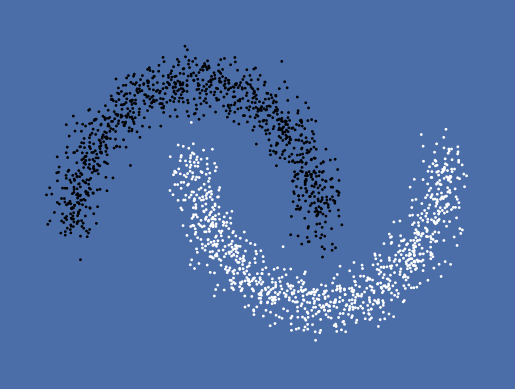

In [4]:
X, Y = make_moons(n_samples=2000, noise=0.1)

x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Plot the dataset
def plot_data(ax: Axes, X: NDArray, Y: NDArray):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

%matplotlib inline
plot_data(ax, X, Y)
plt.show()


In [9]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))


# plot the decision boundary of our classifier
def plot_decision_boundary(ax: Axes, X, Y, classifier: Union["MyReLU", "MySigmoid"]):
    # forward pass on the grid, then convert to numpy for plotting

    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)

    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z > 0.5, cmap="Blues")

    # then plot the dataset
    plot_data(ax, X, Y)

## 2. MLP in numpy

We code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

In [18]:
class MyReLU(object):
    def __init__(self):
        self.input_x = None

    def forward(self, x) -> NDArray:
        # The ReLU is y_i = max(0, x_i)
        self.input_x = x
        return np.maximum(0, x)

    def backward(self, grad_output) -> NDArray:
        # The gradient is 1 for the inputs that were above 0, 0 elsewhere
        if self.input_x is None:
            raise ValueError("Forward pass must be called before backward pass.")
        grad_input = grad_output.copy()
        grad_input[self.input_x <= 0] = 0
        return grad_input

    def step(self, learning_rate):
        # No need to do anything here, since ReLU has no parameters
        pass


class MySigmoid(object):
    def forward(self, x) -> NDArray:
        # the sigmoid is y_i = 1./(1+exp(-x_i))
        return 1. / (1. + np.exp(-x))
    
    def backward(self, grad_output) -> NDArray:
        # the partial derivative is e^-x / (e^-x + 1)^2
        sigmoid = self.forward(grad_output)
        return grad_output * sigmoid * (1 - sigmoid)
    
    def step(self, learning_rate):
        # no need to do anything here since Sigmoid has no parameters
        pass


Probably a good time to test your functions...

In [20]:
test_relu = MyReLU()
x = np.array([0, -1, 0.5, -0.5, 0.8, 1])
output = test_relu.forward(x)
grad_output = np.ones_like(output)
print(grad_output)
grad_input = test_relu.backward(grad_output)
print(grad_input)

[1. 1. 1. 1. 1. 1.]
[0. 0. 1. 0. 1. 1.]


In [ ]:
test_sig = MySigmoid()

test_sig.forward(np.ones(1))

In [ ]:
test_sig.backward(np.ones(1))

A bit more complicated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.

In [ ]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        # initialize two random matrices for W and b (use np.random.randn)
        # YOUR CODE HERE
        raise NotImplementedError()

    def forward(self, x):
        # save a copy of x, you'll need it for the backward
        # return Wx + b
        # YOUR CODE HERE
        raise NotImplementedError()

    def backward(self, grad_output):
        # y_i = \sum_j W_{i,j} x_j + b_i
        # d y_i / d W_{i, j} = x_j
        # d loss / d y_i = grad_output[i]
        # so d loss / d W_{i,j} = x_j * grad_output[i]  (by the chain rule)
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # d y_i / d b_i = 1
        # d loss / d y_i = grad_output[i]
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # now we need to compute the gradient with respect to x to continue the back propagation
        # d y_i / d x_j = W_{i, j}
        # to compute the gradient of the loss, we have to sum over all possible y_i in the chain rule
        # d loss / d x_j = \sum_i (d loss / d y_i) (d y_i / d x_j)
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def step(self, learning_rate):
        # update self.W and self.b in the opposite direction of the stored gradients, for learning_rate
        # YOUR CODE HERE
        raise NotImplementedError()

Code your network. Note that with a Sigmoid layer, you should use the Binary Cross Entropy (BCE) loss.

In [ ]:
class Sequential(object):
    def __init__(self):
        # Specify your model's Architecture here (Use your Linear and Activation Functions)
        # YOUR CODE HERE
        raise NotImplementedError()
        
    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def compute_loss(self, out, label):
        # use the BCE loss
        # -(label * log(output) + (1-label) * log(1-output))
        # save the gradient, and return the loss      
        # beware of dividing by zero in the gradient.
        # split the computation in two cases, one where the label is 0 and another one where the label is 1
        # add a small value (1e-10) to the denominator
        # YOUR CODE HERE
        raise NotImplementedError()

    def backward(self):
        # apply backprop sequentially, starting from the gradient of the loss
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def step(self, learning_rate):
        # take a gradient step for each layers
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
# define your network with your Sequential Class
# YOUR CODE HERE

raise NotImplementedError()

In [ ]:
losses = []
learning_rate = 1e-2
epochs = 10
for epoch in range(epochs):
    for it in range(len(X)):
        # pick a random example idx
        # YOUR CODE HERE

        # select the corresponding example and label
        # YOUR CODE HERE

        # do a forward pass on the example
        # YOUR CODE HERE
        raise NotImplementedError()

        # compute the loss according to your output and the label
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # backward pass
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # gradient step
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
%matplotlib inline
plt.plot(losses)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, yourNetwork)
fig.canvas.draw()

## 3. Using a Pytorch module

In this last part, use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

## 3.1. Load & Preprocess the IMDB Dataset

In this section, you are required to read and load the provided `csv` file, and perform the preprocessing steps as specified in the assignment's description.

## Dataset
The `imdb_dataset.csv` file contains data about around 50000 people reviews from [imdb](https://imdb.com) and their sentiments. The dataset was gathered from [this link](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

In [ ]:
# YOUR CODE HERE

## 3.2. MLP in torch

In [ ]:
import torch
import torch.nn as nn

# y = Wx + b
class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        # YOUR CODE HERE
        raise NotImplementedError()

    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()
        
class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
        
    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [ ]:
# Define your dataloader here (specify your batch_size)
# Use:
from torch.utils.data import TensorDataset, DataLoader
# Note that you should transform your X, y to torch.Tensor

In [ ]:
# define your network with nn.Sequential
# use MyLinear_mod, MyReLU_mod and nn.Sigmoid (from pytorch)

# YOUR CODE HERE

raise NotImplementedError()

In [ ]:
from torch import optim

optimizer = optim.SGD(yourTorchNetwork.parameters(), lr=...)

losses = []
criterion = nn.BCELoss()
epochs = ...
for epoch in range(epochs):
    # You can print epoch No. and train/test accuracy here (after each epoch)
    for batch in yourTrainDataloader:
        # do a forward pass on the batch
        # YOUR CODE HERE
        raise NotImplementedError()

        # compute the loss according to your output and the label
        # YOUR CODE HERE
        raise NotImplementedError()

        # zero the gradients
        # YOUR CODE HERE
        raise NotImplementedError()

        # backward pass
        # YOUR CODE HERE
        raise NotImplementedError()

        # gradient step
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
plt.plot(losses)

In [ ]:
# print the classification_report